<a href="https://colab.research.google.com/github/emm-gl/WA2501_Machine_Learning_AI/blob/main/M%26DL2501-Math%26DeepLearning/Bloque01/Reto%20I%3A%20Math%20%26%20Deep%20learning/Reto_I_Math_%26_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First open: Sat 6 Dec 2025

Emmanuel Gonzalez

# Reto I: Math & Deep learning

Este reto busca que los estudiantes comparen la diferencia entre los
polinomios y las redes neuronales como funciones de Machine
Learning.

* Considerando la siguiente base de datos con información sobre propiedades se deben de tomar las tres variables numéricas (ni binarias ni categóricas) más correlacionadas con el costo de las propiedades.

*  Se deben de entrenar por separado una regresión polinomial con el polinomio sin un grado fijo y una red neuronal sin un número fijo de neuronas o capas.

* El alumno fijará una definición cuantitativa del sobre-ajuste que sea adecuada al problema de regresión que se está solucionando.

* Contar en ambos modelos el número de parámetros entrenables a partir del cual ocurre el sobre-ajuste. Recomendamos jugar con todos los parámetros involucrados.

* ¿Qué nos dice esto sobre la comparación entre redes y polinomios como funciones no-lineales?

**Acerca del dataset:**

El conjunto de datos provienen del Challenge Real estate price prediction del Instituto Louis Bachelier

Se trata de dos archivos CSV, uno con la características explicativas (X) y otro con la etiqueta(y).

La etiqueta (y) representa el precio en euros de bienes inmuebles en Francia.

Las características (X) contienen:

* un identificador del anuncio el tipo de propiedad (casa, apartamento, condominio, mansión...) la ubicación (latitud aproximada, longitud aproximada, ciudad, código postal, exposición, piso cuando proceda...)
* el tamaño (superficie habitable y superficie del terreno cuando proceda),
* el número de habitaciones, dormitorios, baños...
indicadores de eficiencia energética (energía y emisiones de gases de efecto invernadero)
* el número de fotos adjuntas al anuncio
indicadores de si hay sótano, balcón, aire acondicionado...
Además se presenta un diccionario de datos en formato xlsx

**Notas proias:**
El modelo debe de predecir de manera correcta el precio de la propiedad solo considerando las tres variables númericas que tiene el dataset

In [18]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

In [19]:
#Versión de Tensor Flow
tf.__version__

'2.19.0'

# 1. Cargar datos

In [20]:
x_url = "https://raw.githubusercontent.com/emm-gl/WA2501_Machine_Learning_AI/refs/heads/main/M%26DL2501-Math%26DeepLearning/Bloque01/Reto%20I%3A%20Math%20%26%20Deep%20learning/X.csv"
y_url = "https://raw.githubusercontent.com/emm-gl/WA2501_Machine_Learning_AI/refs/heads/main/M%26DL2501-Math%26DeepLearning/Bloque01/Reto%20I%3A%20Math%20%26%20Deep%20learning/y.csv"
xdf = pd.read_csv(x_url)
ydf = pd.read_csv(y_url)

# Unir por la columna "id_annonce"
df_org = pd.merge(xdf, ydf, on="id_annonce", how="inner")
df_org

,id_annonce,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,...,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors,price
0,35996577,appartement,43.643880,7.117183,villeneuve-loubet,6270,63.0,NaN,NaN,NaN,...,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,355000.0
1,35811033,appartement,45.695757,4.895610,venissieux,69200,90.0,3.0,NaN,223.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190000.0
2,35731841,maison,47.966791,-1.220451,moutiers,35130,61.0,NaN,370.0,NaN,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39000.0
3,35886765,maison,47.289292,-1.878805,cordemais,44360,142.0,NaN,764.0,217.0,...,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,299000.0
4,35781137,appartement,45.718992,4.844234,lyon-7eme,69007,88.0,3.0,NaN,NaN,...,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,478000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37363,35881571,appartement,43.480292,-1.484324,bayonne,64100,2995.0,NaN,NaN,255.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190000.0
37364,35890109,appartement,48.861391,2.401158,paris-20eme,75020,36.0,4.0,NaN,229.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399000.0
37365,36010245,appartement,44.397837,-1.164312,biscarrosse,40600,99.0,2.0,NaN,NaN,...,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,328000.0
37366,35864579,duplex,48.864204,2.808693,magny-le-hongre,77700,9281.0,NaN,NaN,NaN,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463000.0


In [21]:
url_dic = "https://github.com/emm-gl/WA2501_Machine_Learning_AI/raw/refs/heads/main/M&DL2501-Math&DeepLearning/Bloque01/Reto%20I:%20Math%20&%20Deep%20learning/DataDictionary.xlsx"
df_dic = pd.read_excel(url_dic)
df_dic

,Name (Type),Description,Compulsory field on web platform
0,id_annonce (str),unique listing identification code,True
1,price (float),price at which the property is listed,True
2,property_type (str),"property type (house, appatement…)",True
3,approximate_latitude (float),latitude of the proporty with a small random g...,False
4,approximate_longitude (float),longitude of the proporty with a small random ...,False
5,city (str),city in which the property is located,True
6,postal_code (int),postal code of the property,True
7,size (float),living area of the property,False
8,floor (float),floor at which the property is located,False
9,land_size (float),size of the land that comes with the property,False


# 2. EDA básico

In [22]:
print(df_org.shape)
print(df_org.dtypes)
print(df_org.isna().sum())
print(df_org["price"].value_counts())

(37368, 28)
id_annonce                       int64
property_type                   object
approximate_latitude           float64
approximate_longitude          float64
city                            object
postal_code                      int64
size                           float64
floor                          float64
land_size                      float64
energy_performance_value       float64
energy_performance_category     object
ghg_value                      float64
ghg_category                    object
exposition                      object
nb_rooms                       float64
nb_bedrooms                    float64
nb_bathrooms                   float64
nb_parking_places              float64
nb_boxes                       float64
nb_photos                      float64
has_a_balcony                  float64
nb_terraces                    float64
has_a_cellar                   float64
has_a_garage                   float64
has_air_conditioning           float64
last_floor   

# 3. Preprocesamiento

In [31]:
# (a) Elegir variables númericas:

KeepColumns = ["approximate_latitude", "approximate_longitude", "postal_code", "floor", "size", "land_size", "energy_performance_value", "ghg_value", "nb_rooms", "nb_bedrooms","nb_bathrooms", "nb_parking_places", "price"]
df = df_org[KeepColumns]

print(df.shape)
print(df.dtypes)
print(df.isna().sum())
print(df["price"].value_counts())

(37368, 13)
approximate_latitude        float64
approximate_longitude       float64
postal_code                   int64
floor                       float64
size                        float64
land_size                   float64
energy_performance_value    float64
ghg_value                   float64
nb_rooms                    float64
nb_bedrooms                 float64
nb_bathrooms                float64
nb_parking_places           float64
price                       float64
dtype: object
approximate_latitude            0
approximate_longitude           0
postal_code                     0
floor                       27625
size                          512
land_size                   21787
energy_performance_value    18300
ghg_value                   18838
nb_rooms                     1566
nb_bedrooms                  2733
nb_bathrooms                13273
nb_parking_places               0
price                           0
dtype: int64
price
299000.0    211
210000.0    197
199000.0    1

In [32]:
# (b) Imputación de valores Nan:

df = df.copy()
#Imputación de variables discretas con moda:
columnas_discretas = ["floor", "nb_rooms", "nb_bedrooms", "nb_bathrooms", "nb_parking_places"]

# Redondear, imputar con moda y convertir a entero
for col in columnas_discretas:
    # Redondear valores existentes
    df[col] = df[col].round()

    # Imputar con moda y asignar de nuevo a la columna
    # Asegurarse de que el cálculo de la moda se hace sobre los valores no nulos
    if df[col].notna().any(): # Check if there are any non-NaN values to calculate a mode from
        moda = df[col].mode()[0]
    else:
        moda = 0 # Default to 0 if all values are NaN
    df[col] = df[col].fillna(moda)

    df[col] = df[col].astype(int)

#Imputación de variables continuas con media:
# Lista de columnas continuas
columnas_continuas = ['size', 'land_size', 'energy_performance_value', 'ghg_value']

# Imputar con media y asignar de nuevo a la columna
for col in columnas_continuas:
    if col in df.columns:
        media = df[col].mean()
        df[col] = df[col].fillna(media)

print(df.shape)
print(df.dtypes)
print(df.isna().sum())

(37368, 13)
approximate_latitude        float64
approximate_longitude       float64
postal_code                   int64
floor                         int64
size                        float64
land_size                   float64
energy_performance_value    float64
ghg_value                   float64
nb_rooms                      int64
nb_bedrooms                   int64
nb_bathrooms                  int64
nb_parking_places             int64
price                       float64
dtype: object
approximate_latitude        0
approximate_longitude       0
postal_code                 0
floor                       0
size                        0
land_size                   0
energy_performance_value    0
ghg_value                   0
nb_rooms                    0
nb_bedrooms                 0
nb_bathrooms                0
nb_parking_places           0
price                       0
dtype: int64


In [35]:
from scipy.stats import spearmanr, kendalltau
import pandas as pd

def analizar_correlaciones_multiples(df, target='price'):
    """
    Compara Pearson, Spearman y Kendall
    """
    features = [col for col in df.columns if col != target]

    resultados = []

    for feature in features:
        # Pearson (lineal)
        pearson = df[feature].corr(df[target])

        # Spearman (monótona, no lineal)
        spearman, _ = spearmanr(df[feature], df[target])

        # Kendall (similar a Spearman, más robusto)
        kendall, _ = kendalltau(df[feature], df[target])

        resultados.append({
            'Feature': feature,
            'Pearson': pearson,
            'Spearman': spearman,
            'Kendall': kendall,
            'Diferencia': abs(spearman - pearson)
        })

    resultados_df = pd.DataFrame(resultados)
    resultados_df = resultados_df.sort_values('Spearman', ascending=False, key=abs)

    print("=" * 90)
    print("📊 COMPARACIÓN DE CORRELACIONES")
    print("=" * 90)
    print(resultados_df.to_string(index=False))
    print("=" * 90)

    # Identificar variables con relaciones no lineales
    print("\n🔍 VARIABLES CON RELACIONES NO LINEALES (|Spearman - Pearson| > 0.05):")
    no_lineales = resultados_df[resultados_df['Diferencia'] > 0.05]
    if len(no_lineales) > 0:
        print(no_lineales[['Feature', 'Pearson', 'Spearman', 'Diferencia']].to_string(index=False))
    else:
        print("   No se detectaron diferencias significativas")

    return resultados_df

# Usar
correlaciones = analizar_correlaciones_multiples(df, target='price')

📊 COMPARACIÓN DE CORRELACIONES
                 Feature   Pearson  Spearman   Kendall  Diferencia
                nb_rooms  0.303781  0.363855  0.266721    0.060074
             nb_bedrooms  0.288266  0.361016  0.270508    0.072750
            nb_bathrooms  0.172911  0.283927  0.231984    0.111016
energy_performance_value -0.023417 -0.192002 -0.137185    0.168584
                    size  0.034083  0.160886  0.113961    0.126804
                   floor  0.089684  0.158355  0.125536    0.068670
             postal_code  0.122125  0.154639  0.102417    0.032514
       nb_parking_places  0.064793  0.133793  0.109316    0.069000
               ghg_value -0.013048 -0.089533 -0.064536    0.076484
   approximate_longitude  0.095404  0.071384  0.047104    0.024020
    approximate_latitude  0.034801  0.045968  0.030268    0.011166
               land_size  0.036016  0.036806  0.027178    0.000790

🔍 VARIABLES CON RELACIONES NO LINEALES (|Spearman - Pearson| > 0.05):
                 Feature   

📊 Correlación de Pearson con 'price':
nb_rooms                 :  0.3038
nb_bedrooms              :  0.2883
nb_bathrooms             :  0.1729
postal_code              :  0.1221
approximate_longitude    :  0.0954
floor                    :  0.0897
nb_parking_places        :  0.0648
land_size                :  0.0360
approximate_latitude     :  0.0348
size                     :  0.0341
ghg_value                : -0.0130
energy_performance_value : -0.0234


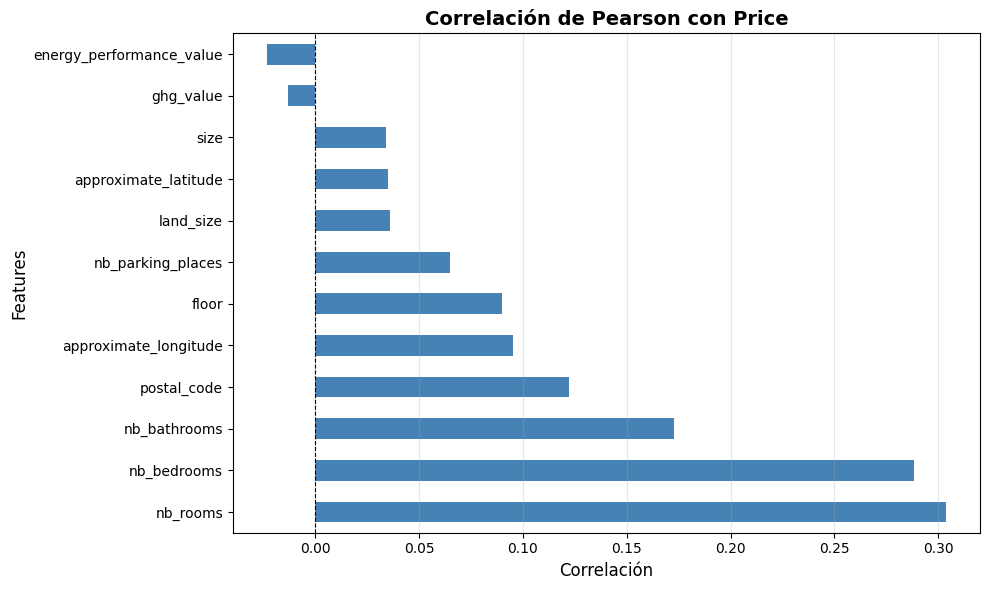

In [33]:
# (C) Correlación de variables numéricas:

correlaciones = df.corr()['price'].drop('price').sort_values(ascending=False)

print("📊 Correlación de Pearson con 'price':")
print("=" * 60)
for feature, corr in correlaciones.items():
    print(f"{feature:25s}: {corr:7.4f}")
print("=" * 60)

# Visualizar
plt.figure(figsize=(10, 6))
correlaciones.plot(kind='barh', color='steelblue')
plt.title('Correlación de Pearson con Price', fontsize=14, fontweight='bold')
plt.xlabel('Correlación', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Se eligen las siguientes tres variables más correlacionadas con el precio:

1. nb_rooms (Solo se tomará nb_rooms por su mayor correlación y no banio, ni recamara para evitar colinealidad ).
2. approximate_longitude y approximate_latitude: Para la ubicación de la propiedad dado que el código postal es una variable categórica.
3. size: Dado que la superficie es importante.

In [56]:
df = df[["approximate_latitude", "approximate_longitude", "size", "nb_rooms", "price"]]
df

,approximate_latitude,approximate_longitude,size,nb_rooms,price
0,43.643880,7.117183,63.0,3,355000.0
1,45.695757,4.895610,90.0,5,190000.0
2,47.966791,-1.220451,61.0,2,39000.0
3,47.289292,-1.878805,142.0,4,299000.0
4,45.718992,4.844234,88.0,4,478000.0
...,...,...,...,...,...
37363,43.480292,-1.484324,2995.0,1,190000.0
37364,48.861391,2.401158,36.0,2,399000.0
37365,44.397837,-1.164312,99.0,4,328000.0
37366,48.864204,2.808693,9281.0,5,463000.0


In [59]:
# (c) Definir target and predictores
target_col = "price"
y = df[target_col]

# Separar features
X = df.drop(columns=[target_col])
num_features = ['approximate_latitude', 'approximate_longitude', 'size', 'nb_rooms']

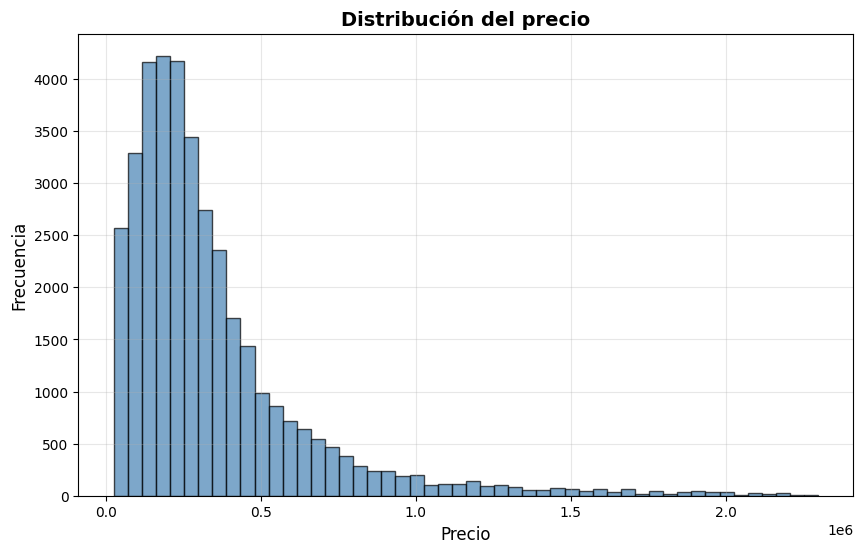

In [60]:
# Histograma simple
plt.figure(figsize=(10, 6))
plt.hist(y, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Precio', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución del precio', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.show()

# 4. Construir pipeline de preprocessing ***************

In [61]:
# Encoders / scalers
num_scaler = StandardScaler()

In [62]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_scaler, num_features)
    ],
    remainder="drop"  # drop price (tu target)
)



# 5. Train / validation / test split

In [53]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42
)

In [54]:
print("Número de registros X_train_full:", len(X_train_full))
print("Número de registros y_train_full:", len(y_train_full))

print("Número de registros X_test:", len(X_test))
print("Número de registros y_test:", len(y_test))

print("Número de registros X_train:", len(X_train))
print("Número de registros y_train:", len(y_train))

print("Número de registros X_val:", len(X_val))
print("Número de registros y_val:", len(y_val))

Número de registros X_train_full: 31762
Número de registros y_train_full: 31762
Número de registros X_test: 5606
Número de registros y_test: 5606
Número de registros X_train: 26997
Número de registros y_train: 26997
Número de registros X_val: 4765
Número de registros y_val: 4765


In [63]:
# Ajustar preprocessing en el conjunto training
preprocessor.fit(X_train)

# Transformamos
X_train_prep = preprocessor.transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

input_dim = X_train_prep.shape[1]

In [64]:
print(input_dim)

4


In [65]:
X_train.head(3)

,approximate_latitude,approximate_longitude,size,nb_rooms
1181,44.468037,0.241071,124.0,5
27669,46.119665,3.428655,67.0,3
5817,48.920192,2.284593,81.0,4


In [66]:
X_train_prep

array([[-0.88028038, -0.90781191, -0.16350301,  0.25755748],
       [-0.17843559,  0.3169997 , -0.17291164, -0.415688  ],
       [ 1.01162322, -0.12259976, -0.17060075, -0.07906526],
       ...,
       [ 0.88772164, -0.0586468 , -0.17538759, -0.75231074],
       [ 0.20287419, -1.46129314, -0.17043568,  0.25755748],
       [ 0.9972314 , -0.07402133, -0.17621291, -0.75231074]])

In [67]:
X_train_prep.shape

(26997, 4)

# 6. Definimos nuestro modelo NN

In [ ]:
def make_model(input_dim, dropout_rate=0.3, hidden_units=[64, 32]):
    inputs = layers.Input(shape=(input_dim,))
    x = inputs

    for units in hidden_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

model = make_model(input_dim=input_dim, dropout_rate=0.3, hidden_units=[64, 64, 32,])

f1_metric(y_true, y_pred) function: This is a custom metric function designed to calculate the F1-score, which is particularly useful for binary classification problems, especially when the classes are imbalanced (as seen with your 'Churn' distribution).

In [ ]:
def f1_metric(y_true, y_pred):
    """Compute F1 for binary classification as a custom metric."""
    y_pred_bin = K.cast(K.greater(y_pred, 0.5), "int32")
    y_true_int = K.cast(y_true, "int32")
    tp = K.sum(K.cast(y_true_int * y_pred_bin, "float32"))
    fp = K.sum(K.cast((1 - y_true_int) * y_pred_bin, "float32"))
    fn = K.sum(K.cast(y_true_int * (1 - y_pred_bin), "float32"))
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[f1_metric]
)


Acuerdate que compilar un modelo es prepararlo para el entrenamiento

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 46)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,281 (36.25 KB)

 Trainable params: 9,281 (36.25 KB)

 Non-trainable params: 0 (0.00 B)

This diagram visually represents your neural network. Each box is a layer, showing its name, type, and output shape.

*   **Input Layer**: Where your 46 preprocessed features enter.
*   **Dense Layers**: These are your fully connected hidden layers (64, 64, then 32 neurons).
*   **Dropout Layers**: Regularization layers to prevent overfitting.
*   **Output Layer**: The final `Dense` layer with 1 neuron and `sigmoid` activation for binary classification.

The arrows show the flow of data through the network from input to output.

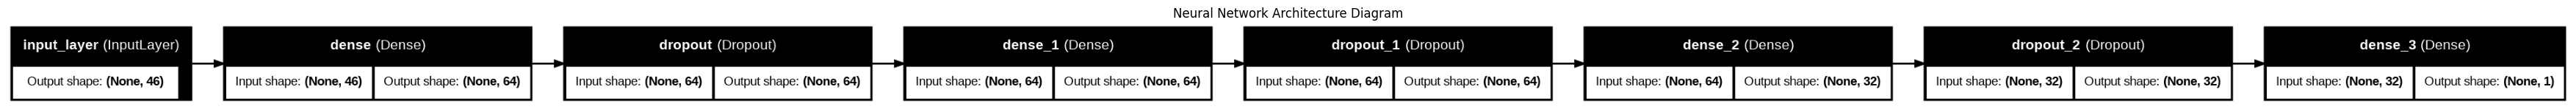

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Generate the plot of the model architecture
plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='LR', # 'TB' for top-down, 'LR' for left-to-right
    expand_nested=True,
    dpi=96
)

# Display the image in the notebook
img = plt.imread('model_architecture.png')
plt.figure(figsize=(45, 30)) # Increased figure size
plt.imshow(img)
plt.axis('off') # Hide axes
plt.title('Neural Network Architecture Diagram')
plt.show()

# 7. Entrenamiento

In [ ]:
early_stop = callbacks.EarlyStopping(
    monitor="val_f1_metric", mode="max", patience=10, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_f1_metric", mode="max", factor=0.5, patience=3
)

history = model.fit(
    X_train_prep,
    y_train,
    validation_data=(X_val_prep, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Epoch 1/100
159/159 - 5s - 34ms/step - f1_metric: 0.1387 - loss: 0.5002 - val_f1_metric: 0.2351 - val_loss: 0.4474 - learning_rate: 1.0000e-03
Epoch 2/100
159/159 - 0s - 3ms/step - f1_metric: 0.2238 - loss: 0.4489 - val_f1_metric: 0.2526 - val_loss: 0.4388 - learning_rate: 1.0000e-03
Epoch 3/100
159/159 - 0s - 3ms/step - f1_metric: 0.2293 - loss: 0.4375 - val_f1_metric: 0.2403 - val_loss: 0.4351 - learning_rate: 1.0000e-03
Epoch 4/100
159/159 - 0s - 3ms/step - f1_metric: 0.2283 - loss: 0.4365 - val_f1_metric: 0.2253 - val_loss: 0.4308 - learning_rate: 1.0000e-03
Epoch 5/100
159/159 - 0s - 3ms/step - f1_metric: 0.2185 - loss: 0.4310 - val_f1_metric: 0.2246 - val_loss: 0.4346 - learning_rate: 1.0000e-03
Epoch 6/100
159/159 - 0s - 3ms/step - f1_metric: 0.2287 - loss: 0.4263 - val_f1_metric: 0.2291 - val_loss: 0.4307 - learning_rate: 5.0000e-04
Epoch 7/100
159/159 - 0s - 3ms/step - f1_metric: 0.2238 - loss: 0.4206 - val_f1_metric: 0.2233 - val_loss: 0.4285 - learning_rate: 5.0000e-04
Epoch

# 8. Evaluación sobre test

In [ ]:
y_test_pred_prob = model.predict(X_test_prep).ravel()
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

print("Test F1:", f1_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Test F1: 0.6203389830508474
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       777
           1       0.59      0.65      0.62       280

    accuracy                           0.79      1057
   macro avg       0.73      0.75      0.74      1057
weighted avg       0.80      0.79      0.79      1057

Confusion matrix:
 [[650 127]
 [ 97 183]]


### Plotting Training History (Loss and F1-score)

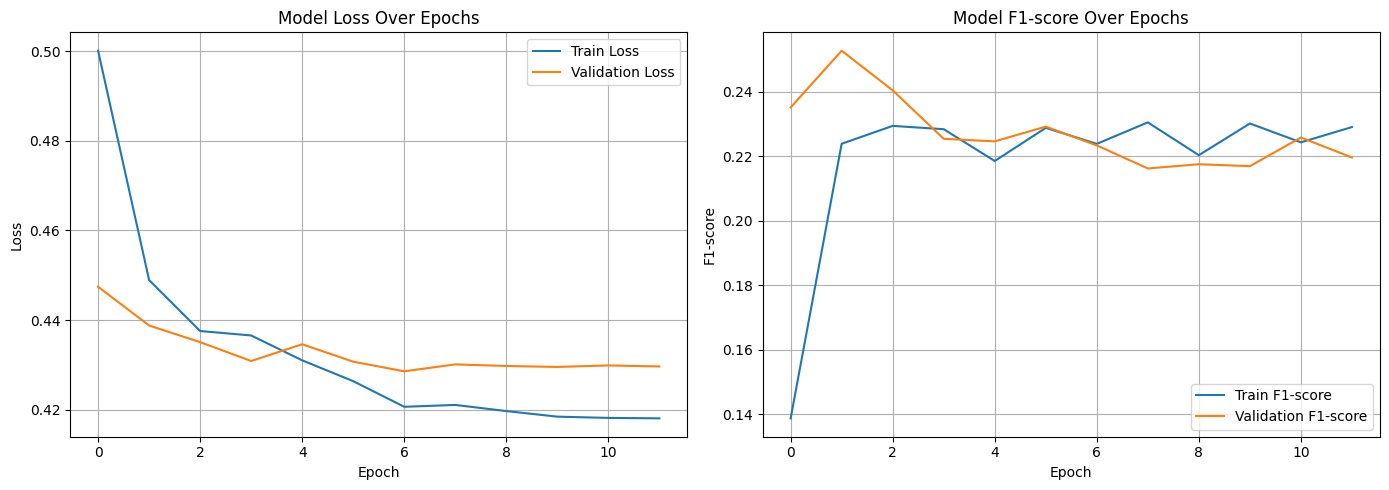

In [ ]:
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

# Plot training & validation f1_metric values
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_metric'], label='Train F1-score')
plt.plot(history.history['val_f1_metric'], label='Validation F1-score')
plt.title('Model F1-score Over Epochs')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

1. Training History (Loss and F1-score)
Imagine you're learning to ride a bike. At first, you fall a lot, and it feels hard. That's like the 'Loss' on the first graph. When the line goes down, it means you're falling less and less, which is good! You're learning.

The other part of this graph, 'F1-score', is like how well you can ride without falling and how many tricks you can do! When this line goes up, it means you're getting super good at bike riding. We want both lines to move in the right direction: loss going down, and F1-score going up! The 'Train' line is how well you're doing while practicing, and 'Validation' is how well you're doing on new roads you haven't seen before.

### Confusion Matrix Heatmap

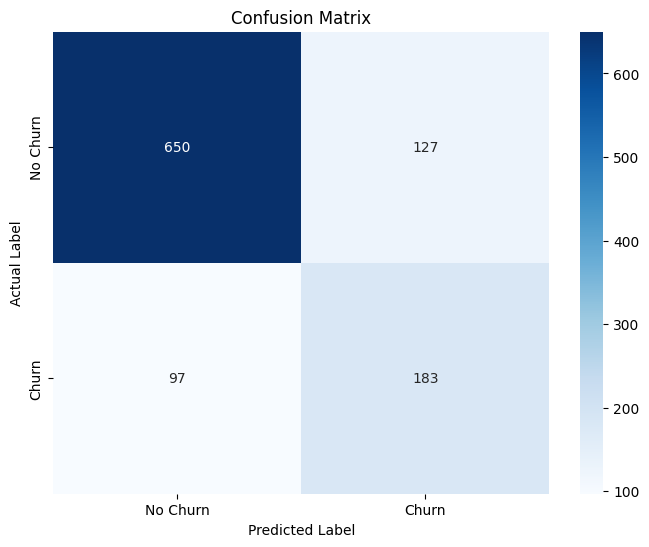

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

2. Confusion Matrix Heatmap
This is like a special scoreboard for our guessing game! Imagine our machine is trying to guess if a customer will leave (Churn) or stay (No Churn).

Top-Left (Blue, 650): Our machine guessed "Stay!" and the customer actually stayed! Yay! That's a correct guess.
Top-Right (Lighter Blue, 127): Our machine guessed "Stay!" but the customer actually left. Oh no! That's a wrong guess.
Bottom-Left (Lighter Blue, 97): Our machine guessed "Leave!" but the customer actually stayed. Oops! Another wrong guess.
Bottom-Right (Blue, 183): Our machine guessed "Leave!" and the customer actually left! Hooray! Another correct guess.
The goal is to have big, dark blue numbers in the corners (top-left and bottom-right) and small, light numbers in the other two spots. It means our machine is good at guessing!

### ROC Curve and AUC

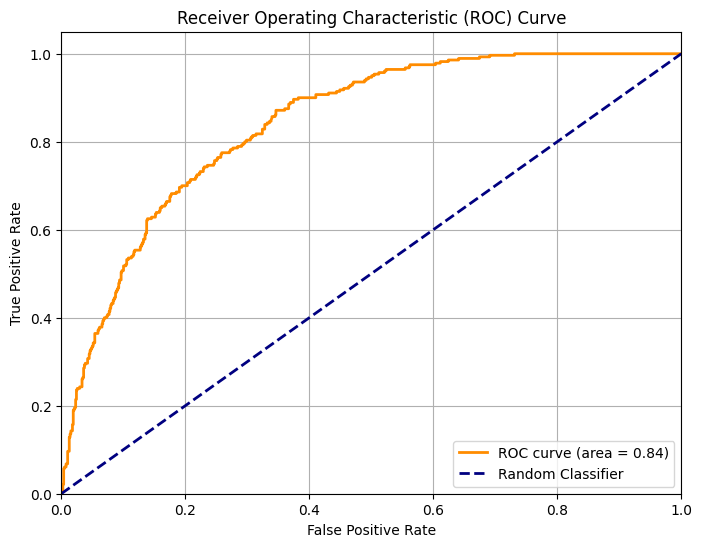

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

3. ROC Curve and AUC
This one is a bit like a "super-tester" for our guessing machine. Imagine you have a magic flashlight that can help you find all the hidden treasures (customers who will churn).

The red line (our machine's magic flashlight) shows how good our machine is at finding all the treasures (True Positives) without accidentally pointing at too many regular rocks (False Positives).
The blue dashed line is like if you just closed your eyes and pointed randomly. You'd find some treasures, but you'd also point at a lot of rocks!
We want our red line to hug the top-left corner as much as possible. The closer it is to that corner, the better our machine's magic flashlight is! The area = 0.84 (AUC) is like how big a treasure map our magic flashlight covers – the closer to 1, the better it is at finding all the hidden treasures.

# 9. Guardamos modelo

In [ ]:
model.save("../models/churn_model.h5")

In [ ]:
import joblib
joblib.dump(preprocessor, "preprocessor.joblib")

['preprocessor.joblib']